# Set-up

note-to-self:
- add RFE to lr model for conversion_ind prediction

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

In [2]:
# check current path
import os
print(os.getcwd())

'''
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/')

path_gdrive = '/content/drive/Shareddrives/Enova/2023/Project_decription'
os.chdir(path_gdrive)
print(os.getcwd())
'''

/Users/anthony/Desktop/Enova/codes


"\n# Load the Drive helper and mount\nfrom google.colab import drive\n# This will prompt for authorization.\ndrive.mount('/content/drive/')\n\npath_gdrive = '/content/drive/Shareddrives/Enova/2023/Project_decription'\nos.chdir(path_gdrive)\nprint(os.getcwd())\n"

In [3]:
path_gdrive = '/Users/anthony/Desktop/Enova/data'
os.chdir(path_gdrive)
print(os.getcwd())

/Users/anthony/Desktop/Enova/data


# Prepare data

In [4]:
train = pd.read_csv('eda_train.csv')
# sanity checks
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             10001 non-null  int64  
 1   residence_type                  10001 non-null  object 
 2   education_level                 10001 non-null  object 
 3   job_type                        10001 non-null  object 
 4   number_years_at_job             10001 non-null  int64  
 5   marital_status                  10001 non-null  int64  
 6   num_tickets_purchased           10001 non-null  float64
 7   gym_membership_ind              10001 non-null  int64  
 8   prior_year_spend                10001 non-null  object 
 9   prior_year_spend_external       10001 non-null  float64
 10  primary_credit_card             10001 non-null  object 
 11  other_streaming_services        10001 non-null  int64  
 12  cable_provider                  

In [5]:
# sanity checkes
#train[['conversion_ind', 'promotion_type']].head()
#train['promotion_type'].value_counts()

In [6]:
# Use transforemd dataset
df = train.copy()

# deal with None/NaN values
df['prior_year_spend'] = df['prior_year_spend'].replace('None', 0)
df['prior_year_spend'] = df['prior_year_spend'].astype(float)
df['prior_year_spend_true'].fillna(0, inplace=True)
df['prior_year_spend_external_true'].fillna(0, inplace=True)

# re-map the promotion types to {gold:3, silver:2, bronze:1} (reverse previous order of 1 and 3)
df['promotion_type'] = df['promotion_type'].map({1:3,2:2, 3:1}).astype(object)

# transform dtype
train['age'] = train['age'].astype(float)

promo_type = df['promotion_type']
conv_ind = df['conversion_ind']
ltv = df['ltv']

In [7]:
df2 = df.drop(['promotion_type', 'conversion_ind', 'ltv'], axis=1)
dfX_dum = pd.get_dummies(df2, drop_first=True)
dfX_dum.head(3)
#dfX_dum.describe()

,age,number_years_at_job,marital_status,num_tickets_purchased,gym_membership_ind,prior_year_spend,prior_year_spend_external,other_streaming_services,activity_social_3y,activity_social_5y,...,primary_credit_card_passport,primary_credit_card_pursuit,primary_credit_card_slamex,cable_provider_DefecTV,cable_provider_Fish Network,cable_provider_Infinity,cable_provider_None,cable_provider_ShrewTube,cable_provider_Spectral,cable_provider_Suboptimal
0,74,10,1,1.0,1,9.10,5.20,3,1,1,...,0,0,0,0,1,0,0,0,0,0
1,51,7,0,2.0,0,27.45,247.43,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,42,7,1,4.0,0,63.63,69.45,5,0,0,...,1,0,0,0,0,0,0,0,1,0


## RFE: RandomForest based classifier

Ref: https://www.kaggle.com/code/residentmario/automated-feature-selection-with-sklearn/notebook

In [8]:
from sklearn.preprocessing import MinMaxScaler

X,y = dfX_dum, conv_ind

scaler = MinMaxScaler()
features = X.columns.values

X_minmax = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

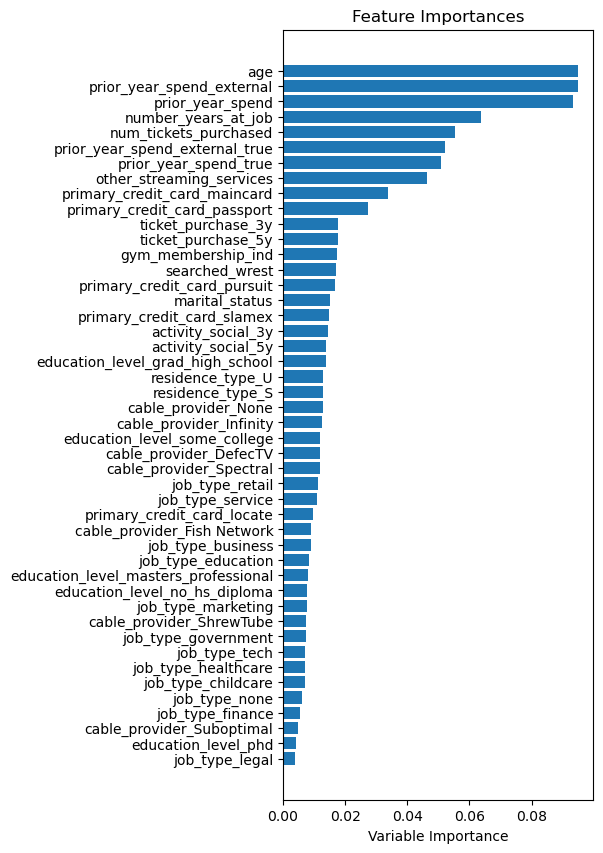

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)

# Plot featrue importances
fig = plt.subplots(figsize=(4,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Variable Importance')
plt.show()

It turns out the EDA and feature engineering is successful. We see original features like `age` and `prior_year_spend` have high feature importance, while new features like `prior_year_spend_true`, `prior_year_spend_external_true` and `search_wrest` are also ranked in the top 15 features.

# Model Training

For a starter, our objective is to:
- `conversion`: predict whether a user will subscribe or not
    - see if the results change if we give promotions
- `ltv`: predict the lifetime value 
- `profit`: net profit = ltv - promotion_cost; we want to maximize the profit

There're different approaches to this problem. This notebook considers a two-fold method combining statistical and ml techniques.

**Review on feature definition**

Before elaborating on the method, let's then recall how the column `conversion_ind` is defined.
>`conversion_ind`: Numerical representation (0 = No, 1 = Yes) of whether or not the individual subscribed to our wrestling streaming platform  
`promotion_type`: Denotes the Promotional Tier offered to the individual to attempt to secure the individual as a subscriber in our wrestling streaming platform

Based on the project description and the definition, we see that each user is provided with a promotion and the user still might or might not subcribe. So, if we want to predict the `conversion_ind`, we need to include `promotion_type` which already affected the probability of `conversion`. Mathmatically, the `conversion_ind` we have is actually: $E[conversion|user, promotion]$.

Meanwhile, for `ltv`, only subsribed users have this `ltv` value, while the others' `ltv` is 0. For predicting `ltv`, it is easy to approache by simply filtering out $E[ltv|user, conversion=1]$ and fit the model.

**Our approache**

Firstly, we want to maximize profit, which is: $$E[profit|user, promotion] = E[Revenue|user, promotion] - E[Cost|user, promotion]$$
Note that $E[Cost|user, promotion]$ is constant give the promotion type is fixed. So the focuse is to find the revenue--in other words, `ltv`.

Secondly, the revenue can be expressed as:$$E[E[ltv|conversion, user, promotion]|user, promotion]$$ 
In other words, the expected revenue depends on whether the user will convert. And the chances fo conversion depends on the user themselves and promotion type.

Also note that when `conversion=0` the `ltv` is 0. So, we are actually finding $E[ltv|conversion=1, user, promotion]$, which depends on $E[conversion|user, promotion]$. The problem is now how to predict the conversion.

Thirdly, as mentioned above, we already know how to calculate $E[ltv|conversion=1, user]$. To save time, we skip users whose `ltv` is less than the minimal cost of promotion ($500).

Then, we take two steps:

Step A: Let's go back to the problem of predicting `P(conversion|user, promotion)`. If we use a GLM model, we will get a baseline probability on whether a user will subscribe or not. Further, with the variable `promotion_type` (which takes ordinal values of 1,2,3), we can calculate the incremental change of effect for promotion. For example, let's say Peter (user#1) has a 76% chance of subscribing (aka. conversion probability). The incremental change of promotion type is $\alpha$, based on this we can have a range of conversion probability (gold, silver, bronze)

Step B: Let the expected revenue be $E[ltv|conversion=1, user, promotion] \times P(conversion=1|user, promotion)$. Following option B, we now have three probabilities of user subscription. Thus, we konw the estimated renvenue. 

In [10]:
#!conda install -c conda-forge xgboost -y

In [11]:
# Importing Classifier Modules
from scipy import stats

from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [12]:
## Model Scores
def print_scores(y_test, Y_pred):
    print("Accuracy score: ", accuracy_score(y_test, Y_pred))
    print("Classification report: \n", classification_report(y_test, Y_pred))
    # print("Precision:", precision_score(y_test, Y_pred))
    # print("Recall:", recall_score(y_test, Y_pred))
    # print("f1 score:", f1_score(y_test, Y_pred))
    # print("AUC:", roc_auc_score(y_test, Y_pred))
    # print("R2 score: ", r2_score(y_test, Y_pred)) 
    # print("Pseudo R2 score: ", 1 - (1-r2_score(y_test, Y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    # print("Confusion matrix: \n", confusion_matrix(y_test, Y_pred))
    # print("Mean Squared Error: ", mean_squared_error(y_test, Y_pred))
    # print("Root MSE: ", np.sqrt(mean_squared_error(y_test, Y_pred)))

def print_scores_reg(y_test, Y_pred):
    print("MAE: ", mean_absolute_error(y_test, Y_pred))
    print("MSE: ", mean_squared_error(y_test, Y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, Y_pred)))
    print("R2 score: ", r2_score(y_test, Y_pred))
    print("Pearson R2 score: ", stats.pearsonr(y_test, Y_pred)[0]**2)
    print("Pseudo R2 score: ", 1 - (1-r2_score(y_test, Y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    

## Prediction on ltv

In [13]:
# extract the target variables
df2 = df[df['conversion_ind']==1] # only train on user whose conversion_ind is 1
ltv = df2['ltv']
df2 = df2.drop(['conversion_ind', 'ltv', 'promotion_type'], axis=1)

# get dummies
dfX_dum = pd.get_dummies(df2, drop_first=True)

# check shape
print(dfX_dum.shape)

# scale the data
from sklearn.preprocessing import MinMaxScaler

X, y = dfX_dum, ltv.values
scaler = MinMaxScaler()
features = X.columns.values
X_minmax = scaler.fit_transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
    train_test_split(X_minmax, y, 
                     test_size=0.3, 
                     random_state=0)

(5040, 46)


In [14]:
ltv_features = dfX_dum.columns

Linear Regression

In [15]:
# linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
print_scores_reg(y_test, y_pred)

MAE:  383.7244991571158
MSE:  3925413.3809897183
RMSE:  1981.2656008192637
R2 score:  -4.213642649184281
Pearson R2 score:  0.13596521570656556
Pseudo R2 score:  -4.377347469568224


Random Forest

In [16]:
# random forest regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print_scores_reg(y_test, y_pred)

MAE:  327.49872215237554
MSE:  185974.88727905045
RMSE:  431.2480577104672
R2 score:  0.7529924851504866
Pearson R2 score:  0.7559231021796506
Pseudo R2 score:  0.745236617790024


XGB

In [17]:
# xgb regression
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print_scores_reg(y_test, y_pred)

MAE:  307.97825335929804
MSE:  171688.3934407738
RMSE:  414.35298169649246
R2 score:  0.7719674736047644
Pearson R2 score:  0.7719689762985634
Pseudo R2 score:  0.7648074079295556


lightgbm regression

In [18]:
# lightgbm regression
import lightgbm as lgb

lgb = lgb.LGBMRegressor()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print_scores_reg(y_test, y_pred)

MAE:  284.3973988760386
MSE:  146088.17872983433
RMSE:  382.21483321534544
R2 score:  0.8059690826815584
Pearson R2 score:  0.8071973330108746
Pseudo R2 score:  0.7998766443220715


For `ltv` prediction, we see that lightGBM has the best performance

## Visualize results

In [19]:
'''from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier()

cat.fit(X_train,y_train)

y_pred = lgb_clf.predict(X_test)
print_scores(y_test, y_pred)'''

# convert numpy array to pandas dataframe
df_test = pd.DataFrame(X_test, columns=ltv_features)

# print the dataframe
df_test.head()

,age,number_years_at_job,marital_status,num_tickets_purchased,gym_membership_ind,prior_year_spend,prior_year_spend_external,other_streaming_services,activity_social_3y,activity_social_5y,...,primary_credit_card_passport,primary_credit_card_pursuit,primary_credit_card_slamex,cable_provider_DefecTV,cable_provider_Fish Network,cable_provider_Infinity,cable_provider_None,cable_provider_ShrewTube,cable_provider_Spectral,cable_provider_Suboptimal
0,0.133333,0.30,1.0,0.000000,1.0,0.000000,0.172752,0.428571,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.050000,0.05,0.0,0.118421,0.0,0.000278,0.145633,0.428571,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.383333,0.40,1.0,0.039474,0.0,0.000503,0.152598,0.714286,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.750000,0.45,0.0,0.013158,0.0,0.001679,0.045528,0.285714,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.533333,0.15,1.0,0.013158,0.0,0.000448,0.296528,0.285714,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
import shap
# compute SHAP values
explainer = shap.Explainer(lgb, X_test)
shap_values = explainer(X_test)

In [21]:

# Calculate SHAP values for a specific observation
sample = df_test.iloc[[10]]
shap_values = explainer.shap_values(sample)

# Create the force plot
shap.force_plot(explainer.expected_value, shap_values, sample)

## Predict on conversion

In [19]:
# extract the target variables
df2 = df.copy()
conv_ind = df2['conversion_ind']
df2 = df2.drop(['conversion_ind', 'ltv'], axis=1)
dfX_dum = pd.get_dummies(df2['promotion_type'], prefix='promotion_type', drop_first=True)
dfX_dum = pd.get_dummies(df2, drop_first=True)

# scale the data
from sklearn.preprocessing import MinMaxScaler

X,y = dfX_dum, conv_ind
scaler = MinMaxScaler()
features = X.columns.values
X = scaler.fit_transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

# hyperparameter setting
random_state = 42

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [20]:
conversion_features = dfX_dum.columns

Logistic Regression

In [21]:
lr = LogisticRegression(random_state=random_state)

lr.fit(X_train, y_train)
Y_pred = lr.predict(X_test)

print_scores(y_test, Y_pred)

Accuracy score:  0.8087304231922693
Classification report: 
               precision    recall  f1-score   support

         0.0       0.83      0.78      0.80      1489
         1.0       0.79      0.84      0.82      1512

    accuracy                           0.81      3001
   macro avg       0.81      0.81      0.81      3001
weighted avg       0.81      0.81      0.81      3001



Decision Tree

In [22]:
dtree = DecisionTreeClassifier(random_state=random_state)
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

print_scores(y_test, y_pred)

Accuracy score:  0.7250916361212929
Classification report: 
               precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      1489
         1.0       0.73      0.72      0.73      1512

    accuracy                           0.73      3001
   macro avg       0.73      0.73      0.73      3001
weighted avg       0.73      0.73      0.73      3001



Random Forest

In [23]:
rf = RandomForestClassifier(random_state= random_state, max_depth=5, min_samples_split=5, min_samples_leaf=5, max_features='auto', oob_score=True, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print_scores(y_test, y_pred)

Accuracy score:  0.769076974341886
Classification report: 
               precision    recall  f1-score   support

         0.0       0.76      0.79      0.77      1489
         1.0       0.78      0.75      0.77      1512

    accuracy                           0.77      3001
   macro avg       0.77      0.77      0.77      3001
weighted avg       0.77      0.77      0.77      3001



Gradient Boosting

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=random_state, n_jobs=-1, learning_rate=0.01)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print_scores(y_test, y_pred)

Accuracy score:  0.793735421526158
Classification report: 
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      1489
         1.0       0.80      0.79      0.79      1512

    accuracy                           0.79      3001
   macro avg       0.79      0.79      0.79      3001
weighted avg       0.79      0.79      0.79      3001



LightGBM

In [25]:
# use lightgbm for classification
from lightgbm import LGBMClassifier
lgb_clf = LGBMClassifier(random_state=random_state, n_jobs=-1, learning_rate=0.01)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
print_scores(y_test, y_pred)

Accuracy score:  0.8060646451182939
Classification report: 
               precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      1489
         1.0       0.81      0.80      0.81      1512

    accuracy                           0.81      3001
   macro avg       0.81      0.81      0.81      3001
weighted avg       0.81      0.81      0.81      3001



Surprisingly, GLM model has one of the best performance, next to lightGBM

## Redo model for `conversion_ind`

In [26]:
# extract the target variables
df2 = df.copy()
conv_ind = df2['conversion_ind']
df2 = df2.drop(['conversion_ind', 'ltv'], axis=1)
dfX_dum = pd.get_dummies(df2, drop_first=True)

# scale the data
from sklearn.preprocessing import MinMaxScaler

X,y = dfX_dum, conv_ind
scaler = MinMaxScaler()
features = X.columns.values
X = scaler.fit_transform(X)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [27]:
# fit logistic regression
lr = LogisticRegression(random_state=random_state)
lr.fit(X, y)

# check the coefficients
feature_names = features.tolist()
promotion_types_idx = [feature_names.index(i) for i in ['promotion_type_2', 'promotion_type_3']]
coefficients = lr.coef_
intercept = lr.intercept_

# Print the coefficients and feature names
print("Exponential of coefficients \n ")
for i in range(len(coefficients)):
    print(f"Coefficients for class {i}:")
    for j in promotion_types_idx:
        print(f"{feature_names[j]}: {np.exp(coefficients[i][j])}")
    print(f"Intercept: {intercept[i]}\n")

Exponential of coefficients 
 
Coefficients for class 0:
promotion_type_2: 5.61347169539306
promotion_type_3: 21.302453410589642
Intercept: -5.49964154086555



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Based on the results, we learn:
- the differences in promotion type between (gold, silver) and bronze
    - if given type2--silver--the odds of subscription will multiply by 5.61
    - if given type3--gold--the odds of subscription will multiply by 21.3
- how to generate adjusted probabilities based on dummy variable

In [28]:
# recall the log coefficients
coef_promotion_type_2 = 5.61347169539306
coef_promotion_type_3 = 21.302453410589642

'''
# calculate probabilities based on promotion type
probs_bronze = lr.predict_proba(X)[:,0]
probs_silver = probs_bronze * coef_promotion_type_2
probs_gold = probs_bronze * coef_promotion_type_3

# insert back to main dataframe
dfX_dum['probs_bronze'] = probs_bronze
dfX_dum['probs_silver'] = probs_silver
dfX_dum['probs_gold'] = probs_gold

dfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].sort_values(by='probs_bronze', ascending=True).head(10)
dfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].describe()
'''

"\n# calculate probabilities based on promotion type\nprobs_bronze = lr.predict_proba(X)[:,0]\nprobs_silver = probs_bronze * coef_promotion_type_2\nprobs_gold = probs_bronze * coef_promotion_type_3\n\n# insert back to main dataframe\ndfX_dum['probs_bronze'] = probs_bronze\ndfX_dum['probs_silver'] = probs_silver\ndfX_dum['probs_gold'] = probs_gold\n\ndfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].sort_values(by='probs_bronze', ascending=True).head(10)\ndfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].describe()\n"

There's a reason that we don't test the calculate on train.csv

In train.csv, each user is provided with different promotion types. Therefore, their "base" probabilities might differ. 

For example, if Sam's base probability of subscription given a 'silver' offer is $P_{S}(Conversion|promotion=silver)$, we can know the other two probabilities based on promotion types as: 
- $P_{S}(Conversion|promotion=bronze) = P_{S}(Conversion|promotion=silver) / 5.61$
- $P_{S}(Conversion|promotion=bronze) = P_{S}(Conversion|promotion=silver) / 5.61 * 21.30$

And imgaine if we have two other users Lulu and Lydia whose base probabilities are $P_{lulu}(Conversion|promotion=gold)$ and $P_{lydia}(Conversion|promotion=gold)$ because they received different types of promotion. This makes it difficult to calculate because we have to adjust the formula according, which is also unnecessary because we won't have this information in validation.csv

Therefore, we have an important assumption for validation.csv, that is, we assume everyone will at least receive a `bronze` promotion. Then we use the Logistic Model above to calculate the corresponding probabilities for other two promotion types.

# Application on Validation.csv

## Data

In [29]:
validation = pd.read_csv('eda_test.csv')
# sanity checks
print(validation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              10000 non-null  int64  
 1   age                             10000 non-null  int64  
 2   residence_type                  10000 non-null  object 
 3   education_level                 10000 non-null  object 
 4   job_type                        10000 non-null  object 
 5   number_years_at_job             10000 non-null  int64  
 6   marital_status                  10000 non-null  int64  
 7   num_tickets_purchased           10000 non-null  float64
 8   gym_membership_ind              10000 non-null  int64  
 9   prior_year_spend                10000 non-null  object 
 10  prior_year_spend_external       10000 non-null  float64
 11  primary_credit_card             10000 non-null  object 
 12  other_streaming_services        1

## Conversion

Note that we don't have the following columns any more: 'conversion_ind', 'ltv', 'promotion_type'

We will assume that everyone has at least one `bronze` promotion and calculate the probabilities accordingly. But that doesn't mean we will actually give the promotion eventually.

The logistic model use `promotion_type_1` (aka. bronze) as base. Therefore, the bronze case is considered within the intercept, which means that we don't need to create a new column named `promotion_type_1` in validation set.

In [30]:
# Use transforemd dataset
df = validation.copy()

# deal with None/NaN values
df['prior_year_spend'] = df['prior_year_spend'].replace('None', 0)
df['prior_year_spend'] = df['prior_year_spend'].astype(float)
df['prior_year_spend_true'].fillna(0, inplace=True)
df['prior_year_spend_external_true'].fillna(0, inplace=True)

# re-map the promotion types to {gold:3, silver:2, bronze:1} (reverse previous order of 1 and 3)
df['promotion_type_2'], df['promotion_type_3'] = 0, 0

# transform dtype
df['age'] = validation['age'].astype(float)

# drop unwanted columns
df = df.drop(['id', 'promotion_type'], axis=1)

In [31]:
# extract the target variables
df2 = df.copy()
# get dummies
dfX_dum = pd.get_dummies(df2, drop_first=True)
print(dfX_dum.shape)

# scale the data
from sklearn.preprocessing import MinMaxScaler

X,y = dfX_dum, conv_ind
scaler = MinMaxScaler()
features = X.columns.values
X = scaler.fit_transform(X)

# hyperparameter setting
random_state = 42

(10000, 48)


In [32]:
# calculate probabilities based on promotion type
probs_bronze = lr.predict_proba(X)[:,0]
probs_silver = probs_bronze * coef_promotion_type_2
probs_gold = probs_bronze * coef_promotion_type_3

# insert back to main dataframe
dfX_dum['probs_bronze'] = probs_bronze
dfX_dum['probs_silver'] = probs_silver
dfX_dum['probs_gold'] = probs_gold

dfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].sort_values(by='probs_bronze', ascending=True).head(10)

,probs_bronze,probs_silver,probs_gold
2581,0.000067,0.000377,0.001431
3268,0.000256,0.001438,0.005456
2601,0.000370,0.002079,0.007891
1357,0.000371,0.002081,0.007899
9400,0.000383,0.002152,0.008166
8746,0.000393,0.002206,0.008371
7807,0.000424,0.002381,0.009035
8916,0.000460,0.002581,0.009796
732,0.000607,0.003408,0.012932
1551,0.000674,0.003785,0.014365


In [33]:
dfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']].describe()

,probs_bronze,probs_silver,probs_gold
count,10000.000000,10000.000000,10000.000000
mean,0.609774,3.422951,12.989690
std,0.356146,1.999218,7.586791
min,0.000067,0.000377,0.001431
25%,0.293746,1.648933,6.257503
50%,0.711478,3.993863,15.156233
75%,0.972598,5.459654,20.718732
max,0.999507,5.610707,21.291960


Now that we have a range of conversion probabilities, we need to decide whether a user will subscribe.

One arbitraty method is to set the bar above 75%. That is, any probabilities among the three `probs_`, if it is >= 75%, we believe this user will subscribe.

In [34]:
def get_promotion(df, prob_threshold=0.75):
    # Create an empty list to store the results
    new_df = df.copy()
    new_df['conv_ind'] = None
    new_df['promotion_type'] = None

    # Loop over each row of the dataframe
    for index, row in df.iterrows():
        # If no value is greater than the threshold, return 0 for conv_ind
        if row.max() < prob_threshold:
            new_df.loc[index, 'conv_ind'] = 0
            #new_df.loc[index, 'promotion_type'] # keep as None for now
            pass
        else:
            # Else, there must be a value that is larger than the threshold
            # Find the minimum value among the features that is greater than the threshold
            for value, row_index in zip(row, row.index):
                if value >= prob_threshold:
                    min_value = value
                    min_index = row_index
                    break
            # Return the minimum value
            new_df.loc[index, 'conv_ind'] = 1
            new_df.loc[index, 'promotion_type_suggest'] = row_index
    # map the `promotion_type` back to {probs_gold:gold, probs_silver:silver, probs_bronze:bronze}
    new_df['promotion_type_suggest'] = new_df['promotion_type_suggest'].map({'probs_gold':'gold', 'probs_silver':'silver', 'probs_bronze':'bronze'})
    # Return the list of results
    return new_df

In [35]:
# get the promotion type
df_tmp = dfX_dum[['probs_bronze', 'probs_silver', 'probs_gold']]
df_tmp_output = get_promotion(df_tmp, prob_threshold=0.85)

# insert back to main dataframe
dfX_dum['conv_ind'] = df_tmp_output['conv_ind'].astype(int)
dfX_dum['promotion_type_suggest'] = df_tmp_output['promotion_type_suggest']

In [36]:
# sanity checks
#dfX_dum.head(5)
dfX_dum.conv_ind.value_counts()
#dfX_dum[dfX_dum['probs_bronze'] < 0.95][['probs_bronze', 'probs_silver', 'probs_gold', 'conv_ind', 'promotion_type']].head(5)

1    8912
0    1088
Name: conv_ind, dtype: int64

## ltv

In [37]:
# use the previous lgb regressor model to predict the ltv
df_tmp = dfX_dum.copy()
df_tmp2 = df_tmp[[i for i in df_tmp.columns if i not in ['probs_bronze', 'probs_silver', 'probs_gold', 'promotion_type_2', 'promotion_type_3', 'promotion_type_suggest', 'conv_ind']]]

print(df_tmp2.shape)

# make predictions on ltv
ltv_validation = lgb.predict(df_tmp2)

# insert back to main dataframe
dfX_dum['ltv'] = ltv_validation * dfX_dum['conv_ind']

(10000, 46)


In [38]:
#dfX_dum.head(3)

Now we are ready to make decisions

In [39]:
# extract essential columns
df_final = dfX_dum[['promotion_type_suggest', 'ltv', 'conv_ind', 'probs_bronze', 'probs_silver', 'probs_gold']]

In [40]:
df_final

,promotion_type_suggest,ltv,conv_ind,probs_bronze,probs_silver,probs_gold
0,gold,1865.039580,1,0.102068,0.572957,2.174304
1,bronze,789.221262,1,0.986791,5.539325,21.021076
2,NaN,0.000000,0,0.029707,0.166758,0.632826
3,silver,2674.527593,1,0.573009,3.216572,12.206504
4,silver,332.631585,1,0.181862,1.020876,3.874101
...,...,...,...,...,...,...
9995,silver,1146.205525,1,0.419817,2.356631,8.943133
9996,NaN,0.000000,0,0.031505,0.176853,0.671138
9997,silver,2538.689969,1,0.475369,2.668471,10.126528
9998,silver,2861.996002,1,0.316496,1.776640,6.742138


In [95]:
#df_final.to_csv('optimization.csv', index=False)